In [1]:
import os, random
from os import path
from numpy.random import seed
import keras
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
from PIL import Image
from keras import layers,models
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tensorflow import random as tfrandom
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger
import time
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras import backend as K
import math
import cv2

#pip install pydot-ng 

# to assure reproducibility
random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path=os.getcwd()

In [3]:
base_path

'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [4]:
dir_path=(base_path+r"\tumor_data")

In [28]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, label in enumerate(os.listdir(dir_path)):
    folder_label = os.path.join(dir_path, label)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_label)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(label) + "_" + str(counts) + ".png"
            src = os.path.join(folder_label, image)
            dst = os.path.join(folder_label, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [6]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [30]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [31]:
# create the directories for each label for each train, validation and test folders

count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for label in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(label)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(label)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(label)))))

In [6]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 # 50% of the 20% in val_test

In [34]:
labels={'label1':708,'label2':1426,'label3':930}

In [36]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [34]:
image_info = {'width': [], 'height': []}
for path in [dir_path+r'\1', dir_path+r'\2', dir_path+r'\3']:
    # for index, letter in enumerate(os.listdir(train_dir)):
    #     folder_letter = os.path.join(train_dir, letter)
    #     file_list = [x for x in os.listdir(folder_letter)]
    
    for _, image in enumerate(os.listdir(path)):      
    # opening the image file and getting size info
        print(image)
        img_path = os.path.join(path, image)
        
        print(img_path)
        img = Image.open(img_path)
        width, height = img.size
        # adding size parameters and filenames to the dictionary
        #image_info['filename'].append(img_filename)
        image_info['width'].append(width)
        image_info['height'].append(height)

# creating a dataframe with the image's sizes
img_df = pd.DataFrame(data=image_info)
# img_df['area'] = img_df['height'] * img_df['width']
# img_df['aspect_ratio'] = img_df['width'] / img_df['height']


1_0.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_0.png
1_1.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_1.png
1_10.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_10.png
1_100.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_100.png
1_101.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_101.png
1_102.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_102.png
1_103.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\tumor_data\1\1_103.png
1_104.png
c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\Deep

In [59]:
# there are 15 images 256*256 pixels
print(len(img_df[(img_df['width']==256) & (img_df['height']==256)]))#.describe().T

print(img_df.describe().T)

# ALL IMAGES ARE SQUARED
print(len(img_df[img_df['width'] != img_df['height']]))


15
         count        mean      std    min    25%    50%    75%    max
width   3064.0  510.746736  17.8709  256.0  512.0  512.0  512.0  512.0
height  3064.0  510.746736  17.8709  256.0  512.0  512.0  512.0  512.0
0


In [6]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=50,
                    rotation_range=10,
                    shear_range=0.05)
                    #horizontal_flip=True )

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

Found 2451 images belonging to 3 classes.


In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [8]:
# AUGMENTED
# train_generator_aug_rgb = train_datagen_aug.flow_from_directory(
#     train_path,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='rgb',
#     seed=42
# )

# train_generator_rgb = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='rgb',
#     seed=42
# )

# val_generator_rgb = val_datagen.flow_from_directory(
#     val_path,
#     target_size=(150, 150),  
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='rgb',
#     seed=42
# )

# test_generator_rgb = test_datagen.flow_from_directory(
#     test_path,
#     target_size=(150, 150), 
#     batch_size=20,
#     class_mode='categorical',
#     color_mode='rgb',
#     seed=42,
#     shuffle=False
# )

Found 2451 images belonging to 3 classes.
Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [5]:
# ADAPTED FROM https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# ADAPTED FROM https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit 
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [7]:
# FUNCTION TO SAVE THE TIME TAKEN BY EACH EPOCH OF A MODEL, IN A CSV FORMAT

def save_times(model, times, name_model):
  
    times_info = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_info[idx] = times[idx]
    df_times = pd.DataFrame(times_info)

    if os.path.exists(r'.\models\models_times.csv'):
        df_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_times.to_csv(r'.\models\models_times.csv')

In [8]:
# FUNCTION TO PLOT F1 AND LOSS
def plot_history(his, patience, model_name):
   
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Model saved')
    plt.title(f'{model_name} - Training and Validation F1 score', pad=15)
    plt.xlabel('Number of Epochs')
    plt.ylabel('F1 score')
    plt.legend()
    plt.figure()

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs, loss,'bo',label='Training Loss')
    plt.plot(epochs, loss_val,'b',label='Validation Loss')
    plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Best Loss value')
    plt.title(f'{model_name} - Training and Validation Loss', pad=15)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

In [9]:
# FUNCTION TO DEFINE THE CALLBACKS

def callback(filename):
  callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
                keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
                ,time_callback]

  return callname_list


In [10]:
# TO OVERCOME THE PROBLEM RISEN BY AN UNKNOWN METRIC, WHEN LOADING A MODEL ALREADY SAVED
dependencies = {
    'f1_m': f1_m
}

In [15]:
# UNDERSTANDING HOW 'STEPS_PER_EPOCH' AND 'VAL_STEPS' ARE DEFINED
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


# MODELS

## First random model

In [29]:
callbacks_BW = callback("\modelBW.h5")

In [30]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8207 - f1_m: 0.4929
Epoch 00001: val_loss improved from inf to 0.66708, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 109s 888ms/step - loss: 0.8207 - f1_m: 0.4929 - val_loss: 0.6671 - val_f1_m: 0.6100
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6018 - f1_m: 0.7187
Epoch 00002: val_loss improved from 0.66708 to 0.54838, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 112s 913ms/step - loss: 0.6018 - f1_m: 0.7187 - val_loss: 0.5484 - val_f1_m: 0.7464
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.5038 - f1_m: 0.7746
Epoch 00003: val_los

In [15]:
#np.save('models/historyBW.npy',history_1st.history)
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW, timesBW,'modelBW')

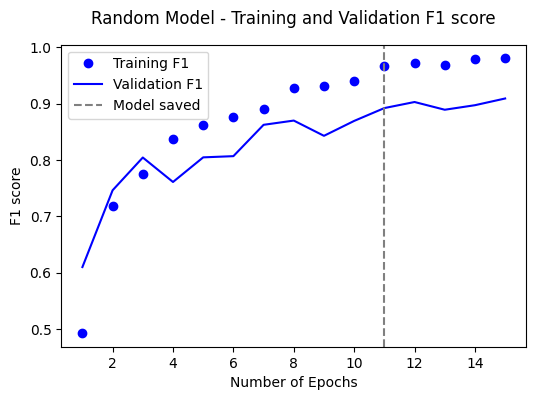

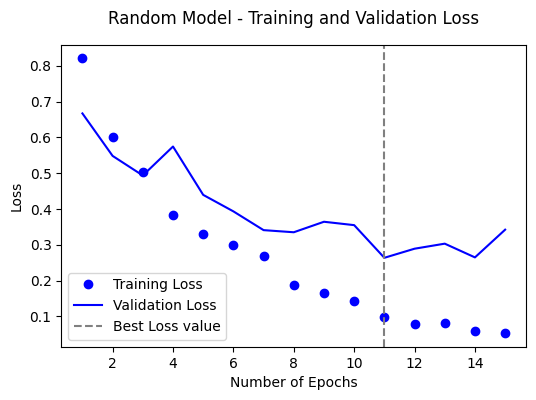

<Figure size 600x400 with 0 Axes>

In [55]:
plot_history(historyBW,4,'Random Model')

## Increasing the number of filters through CNN

In [54]:
callbacks_BW_inc = callback("\modelBW_inc.h5")
#increase the nr of filters through the CNN

In [55]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_2 = model2.fit_generator(train_generator, callbacks=callbacks_BW_inc, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7821 - f1_m: 0.5629
Epoch 00001: val_loss improved from inf to 0.64189, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 66s 536ms/step - loss: 0.7821 - f1_m: 0.5629 - val_loss: 0.6419 - val_f1_m: 0.7159
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5613 - f1_m: 0.7450
Epoch 00002: val_loss improved from 0.64189 to 0.49001, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 72s 581ms/step - loss: 0.5613 - f1_m: 0.7450 - val_loss: 0.4900 - val_f1_m: 0.7882
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4478 - f1_m: 0.8084
Epoch 00003: val_loss did not improve from 0.49001
123/123 [==============================

In [42]:
#np.save('models/historyBW_inc.npy',history_2.history)
modelBW_inc = keras.models.load_model('models/modelBW_inc.h5', custom_objects=dependencies)
historyBW_inc=np.load('models/historyBW_inc.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW_inc, timesBW,'modelBW_inc')

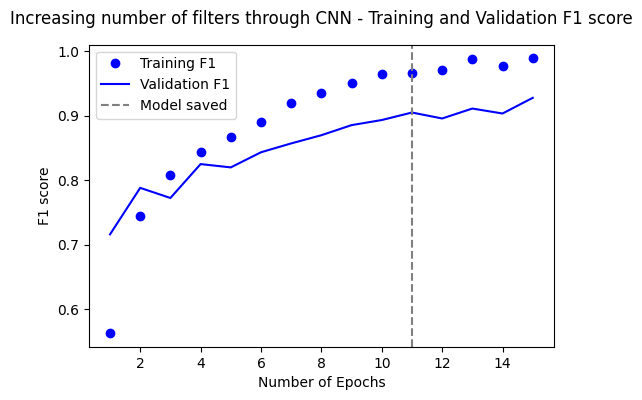

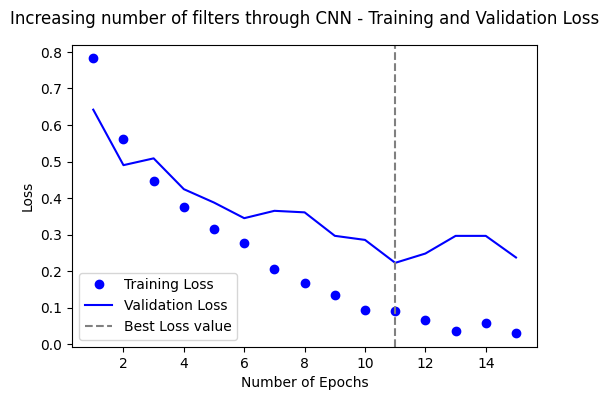

<Figure size 600x400 with 0 Axes>

In [56]:
plot_history(historyBW_inc,4,'Increasing number of filters through CNN')

## Reducing the number of layers to overcome overfitting

In [58]:
callbacks_BW_simple = callback("\modelBW_simple.h5")
#increase the nr of filters through the CNN

In [59]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_3 = model3.fit_generator(train_generator, callbacks=callbacks_BW_simple, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7221 - f1_m: 0.6164
Epoch 00001: val_loss improved from inf to 0.68303, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 81s 657ms/step - loss: 0.7221 - f1_m: 0.6164 - val_loss: 0.6830 - val_f1_m: 0.6612
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5392 - f1_m: 0.7424
Epoch 00002: val_loss improved from 0.68303 to 0.53808, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 77s 623ms/step - loss: 0.5392 - f1_m: 0.7424 - val_loss: 0.5381 - val_f1_m: 0.7250
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4233 - f1_m: 0.8077
Epoch 00003: val_loss improved from 0.53808 to 0.52782, saving model to c:\Users\Uti

In [52]:
#np.save('models/historyBW_simple.npy',history_3.history)
modelBW_simple = keras.models.load_model('models/modelBW_simple.h5', custom_objects=dependencies)
historyBW_simple=np.load('models/historyBW_simple.npy',allow_pickle='TRUE').item()
#timesBW_simple = time_callback.times
#save_times(modelBW_simple, timesBW_simple,'modelBW_simple')

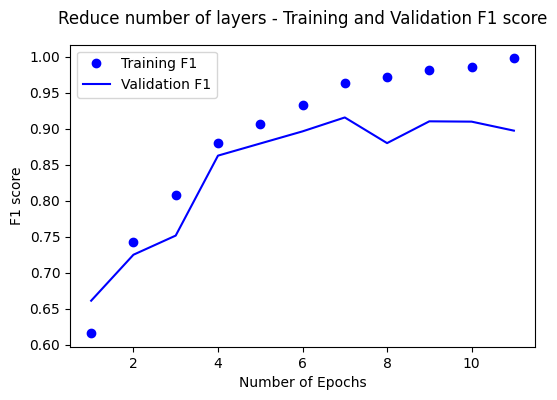

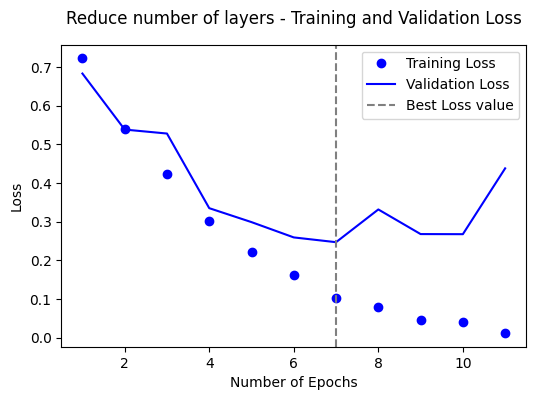

<Figure size 600x400 with 0 Axes>

In [53]:
plot_history(historyBW_simple,4,'Reduce number of layers')

## Introducing data augmentation, drop out of 0.5, reduce patience on EarlyStopping and ReduceLROnPlateau callback to overcome overfitting

In [72]:
def callback(filename):
      callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True),
            time_callback, 
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', min_lr=1e-4)]

      return callname_list

In [73]:
def create_model_drop(input_drop,callbacks_input):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(input_drop))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

    history = model.fit_generator(train_generator_aug, callbacks=callbacks_input, epochs=30, steps_per_epoch=123, validation_steps=16,
                                    validation_data=val_generator, workers=2)
    return history

In [74]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")

In [18]:
history_4=create_model_drop(0.5,callbacks_BW_aug_5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7707 - f1_m: 0.5844
Epoch 00001: val_loss improved from inf to 0.60630, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.7707 - f1_m: 0.5844 - val_loss: 0.6063 - val_f1_m: 0.7426
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5832 - f1_m: 0.7324
Epoch 00002: val_loss improved from 0.60630 to 0.49565, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.5832 - f1_m: 0.7324 - val_loss: 0.4957 - val_f1_m: 0.7823
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4590 - f1_m: 0.7996
Epoch 0000

In [57]:
#np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
#timesBW_aug_5 = time_callback.times
#save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

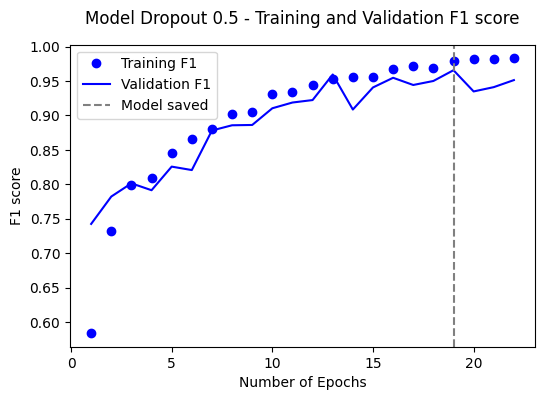

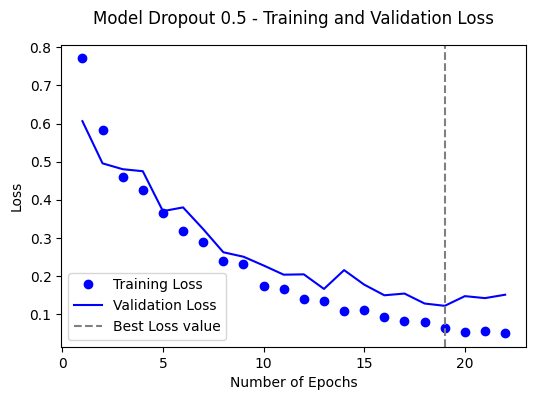

<Figure size 600x400 with 0 Axes>

In [58]:
plot_history(historyBW_aug_5,3,'Model Dropout 0.5')

## Changing drop out to 0.3

In [96]:
callbacks_BW_aug_3 = callback("\modelBW_aug_3.h5")

In [97]:
history_5=create_model_drop(0.3,callbacks_BW_aug_3)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7330 - f1_m: 0.6117
Epoch 00001: val_loss improved from inf to 0.66092, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 73s 592ms/step - loss: 0.7330 - f1_m: 0.6117 - val_loss: 0.6609 - val_f1_m: 0.6600
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5207 - f1_m: 0.7690
Epoch 00002: val_loss improved from 0.66092 to 0.46974, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 80s 649ms/step - loss: 0.5207 - f1_m: 0.7690 - val_loss: 0.4697 - val_f1_m: 0.8069
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4352 - f1_m: 0.8097
Epoch 00003: val_loss improved from 0.46974 to 0.44493, saving model to c:\Users\Utili

In [64]:
#np.save('models/historyBW_aug_3.npy',history_5.history)
modelBW_aug_3 = keras.models.load_model('models/modelBW_aug_3.h5', custom_objects=dependencies)
historyBW_aug_3=np.load('models/historyBW_aug_3.npy',allow_pickle='TRUE').item()
#timesBW_aug_3 = time_callback.times
#save_times(modelBW_aug_3, timesBW_aug_3,'modelBW_aug_3')

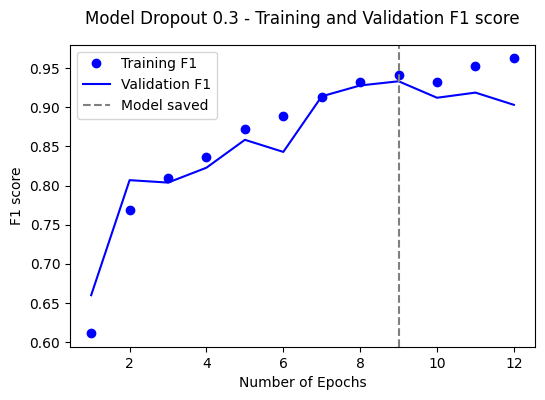

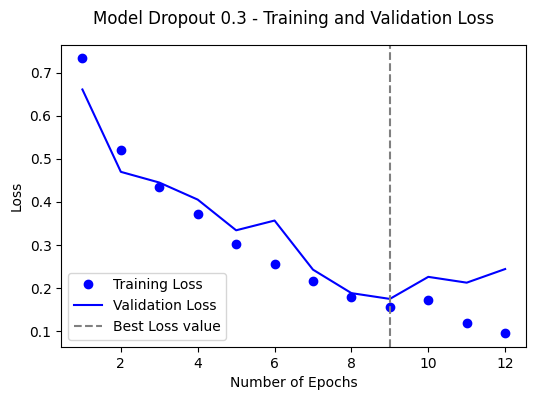

<Figure size 600x400 with 0 Axes>

In [65]:
plot_history(historyBW_aug_3,3,'Model Dropout 0.3')

## Changing drop out to 0.4 

In [103]:
callbacks_BW_aug_4 = callback("\modelBW_aug_4.h5")

In [105]:
history_6=create_model_drop(0.4,callbacks_BW_aug_4)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7503 - f1_m: 0.6051
Epoch 00001: val_loss improved from inf to 0.69886, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 86s 702ms/step - loss: 0.7503 - f1_m: 0.6051 - val_loss: 0.6989 - val_f1_m: 0.7055
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5600 - f1_m: 0.7487
Epoch 00002: val_loss improved from 0.69886 to 0.54631, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 84s 684ms/step - loss: 0.5600 - f1_m: 0.7487 - val_loss: 0.5463 - val_f1_m: 0.7568
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4462 - f1_m: 0.8076
Epoch 00003: val_loss improved from 0.54631 to 0.50075, saving model to c:\Users\Utili

In [11]:
#np.save('models/historyBW_aug_4.npy',history_6.history)
modelBW_aug_4 = keras.models.load_model('models/modelBW_aug_4.h5', custom_objects=dependencies)
historyBW_aug_4=np.load('models/historyBW_aug_4.npy',allow_pickle='TRUE').item()
#timesBW_aug_4 = time_callback.times
#save_times(modelBW_aug_4, timesBW_aug_4,'modelBW_aug_4')

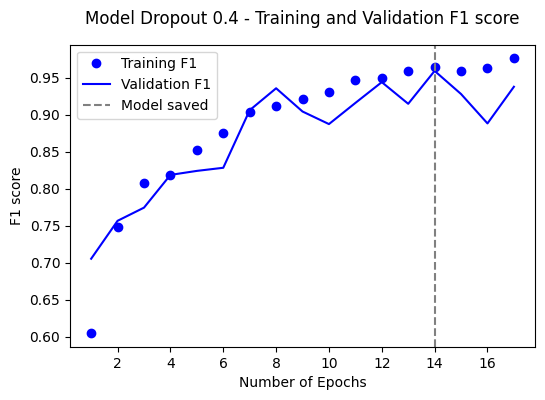

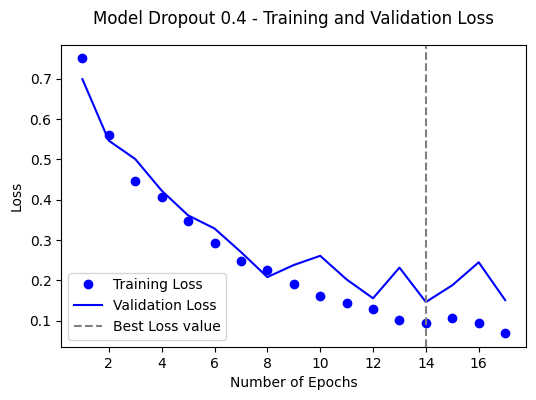

<Figure size 600x400 with 0 Axes>

In [115]:
plot_history(historyBW_aug_4,3,'Model Dropout 0.4')

In [116]:
preds = modelBW_aug_4.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW_aug_4.evaluate_generator(test_generator)
cm

array([[ 65,   5,   1],
       [  5, 135,   2],
       [  1,   0,  92]], dtype=int64)

In [117]:
print(f'Test loss: {test_score[0]} / Test f1score: {test_score[1]}')

Test loss: 0.17702293395996094 / Test accuracy: 0.9489582777023315


In [181]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        71
           1       0.96      0.95      0.96       142
           2       0.97      0.99      0.98        93

    accuracy                           0.95       306
   macro avg       0.95      0.95      0.95       306
weighted avg       0.95      0.95      0.95       306



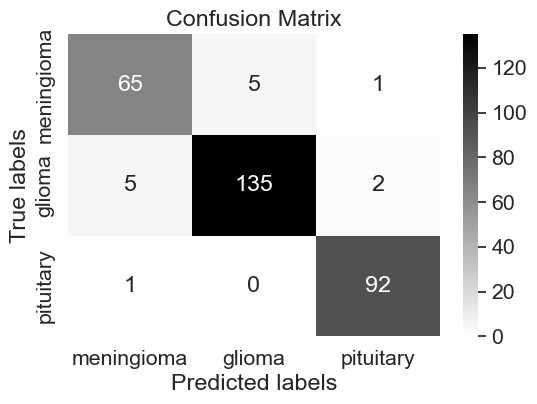

In [126]:
categories = ['meningioma', 'glioma','pituitary']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='binary')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)

plt.show()

In [14]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

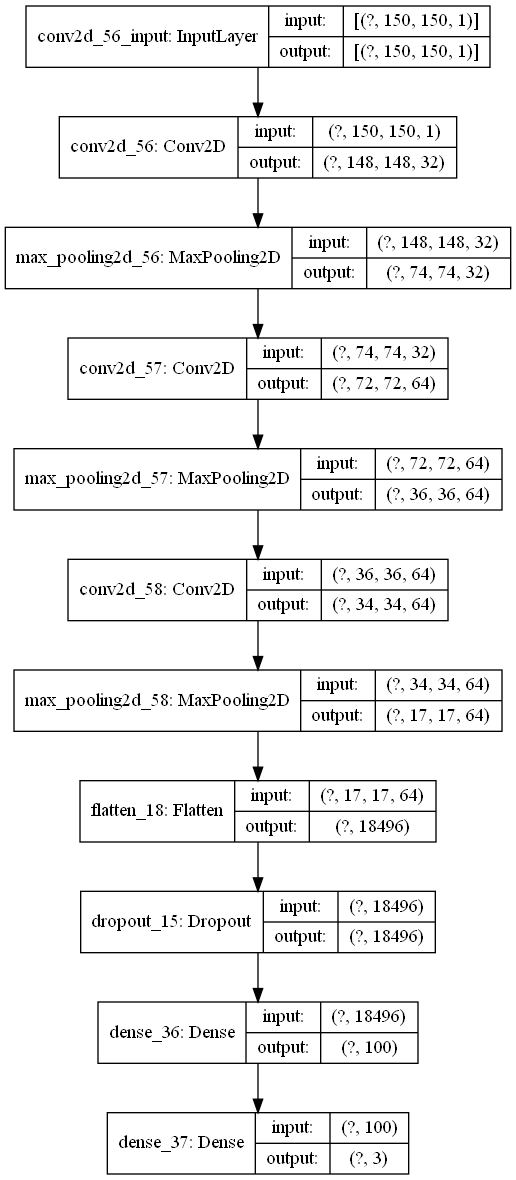

In [15]:
plot_model(modelBW_aug_4, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

# Data augmentation and regularization L1

In [ ]:
def create_model_l1(input_l1,callbacks_input):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1(input_l1)))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

    history = model.fit_generator(train_generator_aug, callbacks=callbacks_input, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)
    return history

In [61]:
#l1=0.001
callbacks_BW_aug_l1 = callback("\modelBW_aug_l1.h5")

In [62]:
history_7=create_model_l1(1e-3,callbacks_BW_aug_l1)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 2.4498 - f1_m: 0.5411
Epoch 00001: val_loss improved from inf to 1.23399, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 82s 667ms/step - loss: 2.4498 - f1_m: 0.5411 - val_loss: 1.2340 - val_f1_m: 0.6361
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.0795 - f1_m: 0.6615
Epoch 00002: val_loss improved from 1.23399 to 1.01014, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 82s 669ms/step - loss: 1.0795 - f1_m: 0.6615 - val_loss: 1.0101 - val_f1_m: 0.6470
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.9911 - f1_m: 0.6949
Epoch 00003: val_loss improved from 1.01014 to 1.00435, saving model to c:\Users\Uti

In [127]:
#np.save('models/historyBW_aug_l1.npy',history_7.history)
modelBW_aug_l1 = keras.models.load_model('models/modelBW_aug_l1.h5', custom_objects=dependencies)
historyBW_aug_l1=np.load('models/historyBW_aug_l1.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1 = time_callback.times
#save_times(modelBW_aug_l1, timesBW_aug_l1,'modelBW_aug_l1')

## 0.00001

In [68]:
callbacks_BW_aug_l1_5 = callback("\modelBW_aug_l1_5.h5")

In [69]:
history_8=create_model_l1(1e-5,callbacks_BW_aug_l1_5)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8319 - f1_m: 0.5987
Epoch 00001: val_loss improved from inf to 0.69171, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_5.h5
123/123 [==============================] - 87s 708ms/step - loss: 0.8319 - f1_m: 0.5987 - val_loss: 0.6917 - val_f1_m: 0.6942
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6348 - f1_m: 0.7228
Epoch 00002: val_loss improved from 0.69171 to 0.60008, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_5.h5
123/123 [==============================] - 80s 647ms/step - loss: 0.6348 - f1_m: 0.7228 - val_loss: 0.6001 - val_f1_m: 0.7651
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.5348 - f1_m: 0.7867
Epoch 00003: val_loss improved from 0.60008 to 0.55194, saving model to c:\Users

In [128]:
#np.save('models/historyBW_aug_l1_5.npy',history_8.history)
modelBW_aug_l1_5 = keras.models.load_model('models/modelBW_aug_l1_5.h5', custom_objects=dependencies)
historyBW_aug_l1_5=np.load('models/historyBW_aug_l1_5.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1_5 = time_callback.times
#save_times(modelBW_aug_l1_5, timesBW_aug_l1_5,'modelBW_aug_l1_5')

## 0.0001

In [75]:
callbacks_BW_aug_l1_4=callback("\modelBW_aug_l1_4.h5")

In [78]:
history_9=create_model_l1(1e-4,callbacks_BW_aug_l1_4)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 1.1150 - f1_m: 0.5778
Epoch 00001: val_loss improved from inf to 0.81752, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_4.h5
123/123 [==============================] - 83s 672ms/step - loss: 1.1150 - f1_m: 0.5778 - val_loss: 0.8175 - val_f1_m: 0.6269
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.7675 - f1_m: 0.7038
Epoch 00002: val_loss improved from 0.81752 to 0.69828, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_4.h5
123/123 [==============================] - 80s 651ms/step - loss: 0.7675 - f1_m: 0.7038 - val_loss: 0.6983 - val_f1_m: 0.7735
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.6793 - f1_m: 0.7621
Epoch 00003: val_loss improved from 0.69828 to 0.64278, saving model to c:\Users

In [129]:
#np.save('models/historyBW_aug_l1_4.npy',history_9.history)
modelBW_aug_l1_4 = keras.models.load_model('models/modelBW_aug_l1_4.h5', custom_objects=dependencies)
historyBW_aug_l1_4=np.load('models/historyBW_aug_l1_4.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1_4 = time_callback.times
#save_times(modelBW_aug_l1_4, timesBW_aug_l1_4,'modelBW_aug_l1_4')

In [179]:
# FUNCTION TO PLOT F1 AND LOSS
def plot_history(his1,his2,his3, patience, name1,name2, name3):
   
    f1_1 = his1['val_f1_m']
    f1_2=his2['val_f1_m']
    f1_3=his3['val_f1_m']
    # loss = his['loss']
    # loss_val=his['val_loss']

    epochs1=range(1,len(f1_1)+1)
    epochs2=range(1,len(f1_2)+1)
    epochs3=range(1,len(f1_3)+1)

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs1, f1_1,'r', label=f'{name1} Validation F1')
    plt.plot(epochs2, f1_2,'b', label=f'{name2} Validation F1')
    plt.plot(epochs3, f1_3,'g', label=f'{name3} Validation F1')
    #plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Model saved')
    plt.title(f'L1 impact comparison - Validation F1 score', pad=15, size=15)
    plt.xlabel('Number of Epochs',fontsize=12)
    plt.ylabel('F1 score',fontsize=12)
    plt.xticks([2,4,6,8,10,12,14,16,18])
    plt.grid(False)
    plt.legend()
    plt.figure()
    
    # plt.rcParams["figure.dpi"] = 100
    # plt.plot(epochs, loss,'bo',label='Training Loss')
    # plt.plot(epochs, loss_val,'b',label='Validation Loss')
    # plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Best Loss value')
    # plt.title(f'{model_name} - Training and Validation Loss', pad=15)
    # plt.xlabel('Number of Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.figure()

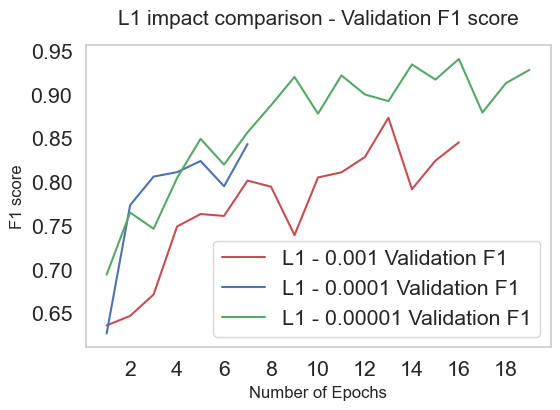

<Figure size 600x400 with 0 Axes>

In [180]:
plot_history(historyBW_aug_l1,historyBW_aug_l1_4,historyBW_aug_l1_5, 3,'L1 - 0.001','L1 - 0.0001', 'L1 - 0.00001')

# TRANSFER LEARNING

In [53]:
# pre_trained=tf.keras.applications.ResNet50(
#                                                     include_top=True,
#                                                     input_shape=(224,224,1),
#                                                     weights='imagenet',
#                                                     input_tensor=None,
                                               
#                                                     pooling=None,
#                                                     classes=1000
#                                                 )

In [19]:
callbacks_trans = callback("\model_trans.h5")

In [26]:
from keras.models import Model
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='max') 
x=base_model.output
x=layers.Dropout(0.4)(x) 
#x = layers.Dense(100,activation='relu')(x)     
output=layers.Dense(3, activation='softmax')(x)
model_trans=Model(inputs=base_model.input, outputs=output)
model_trans.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) 

In [27]:
history_trans = model_trans.fit_generator(train_generator_aug_rgb, callbacks=callbacks_trans, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator_rgb, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 2.3859 - f1_m: 0.6882
Epoch 00001: val_loss improved from inf to 187213.20312, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 1118s 9s/step - loss: 2.3859 - f1_m: 0.6882 - val_loss: 187213.2031 - val_f1_m: 0.4701
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.2509 - f1_m: 0.6791
Epoch 00002: val_loss improved from 187213.20312 to 58592.59766, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 1112s 9s/step - loss: 1.2509 - f1_m: 0.6791 - val_loss: 58592.5977 - val_f1_m: 0.4701
Epoch 3/30
 18/123 [===>..........................] - ETA: 14:07 - loss: 0.5297 - f1_m: 0.7475

KeyboardInterrupt: 

In [58]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = [f1_m])

In [34]:
from keras.models import Model
from keras.layers import Input 

resnet = keras.applications.ResNet50(weights='imagenet',include_top='FALSE') 

input_tensor = Input(shape=(150,150,1) )
x = layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = resnet (x) 

model_trans = keras.Model(inputs=input_tensor,outputs=out)


base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 1))
x = base_model(inputs, training=False)
x = keras.layers.GlobalMaxPooling2D()(x)
outputs = keras.layers.Dense(3)(x)
model_trans = keras.Model(inputs, outputs)


In [109]:
#pip install torchvision

In [60]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = [f1_m])
hist_trans = model.fit(train_generator_aug_rgb,
                    epochs = 20,
                    validation_data = val_generator_rgb,
                    callbacks=callbacks_trans, workers=2)

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 12.3960 - f1_m: 0.3031
Epoch 00001: val_loss improved from inf to 12.39046, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 166s 1s/step - loss: 12.3960 - f1_m: 0.3031 - val_loss: 12.3905 - val_f1_m: 0.3022
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 12.3960 - f1_m: 0.3034
Epoch 00002: val_loss improved from 12.39046 to 12.39046, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 167s 1s/step - loss: 12.3960 - f1_m: 0.3034 - val_loss: 12.3905 - val_f1_m: 0.3022
Epoch 3/20
 24/123 [====>.........................] - ETA: 2:08 - loss: 12.6258 - f1_m: 0.3104

KeyboardInterrupt: 

In [42]:

from keras.models import Model
from keras.layers import Input 

resnet = keras.applications.ResNet50(weights='imagenet',include_top= 'TRUE') 

input_tensor = Input(shape=(224,224,1) )
x = keras.layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
x = keras.layers.Dense(3)(x)
out = resnet (x) 

model = Model(inputs=input_tensor,outputs=out)

In [73]:
preds = modelBW.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW.evaluate_generator(test_generator)

C:\Users\filip\AppData\Local\Temp/ipykernel_7176/1856620179.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = modelBW.evaluate_generator(test_generator)


In [74]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        71
           1       0.92      0.97      0.95       142
           2       0.97      0.97      0.97        93

    accuracy                           0.94       306
   macro avg       0.94      0.92      0.93       306
weighted avg       0.94      0.94      0.94       306



In [ ]:
# Modelo sem aug BW
#  ---- dropout augmentation

# Modelo sem aug RGB
#  ---- dropout augmentation

# funçoes dos plots

# time function comparison